<a href="https://colab.research.google.com/github/pylancer/masters/blob/main/S3DLA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import the required libraries.**

In [ ]:
import os
from google.colab import files
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import cv2 #OpenCV

from tqdm import tqdm #progress bar
import itertools

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #to not print tf info, error and warning messages

**Check the GPU available**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


**Check the RAM available**

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
#Get Classifier File
#https://drive.google.com/file/d/1aKyaXG2ypR-SdOskfeZ2QukdMaLBdtwV/view?usp=share_link
! gdown 1aKyaXG2ypR-SdOskfeZ2QukdMaLBdtwV

Downloading...
From: https://drive.google.com/uc?id=1aKyaXG2ypR-SdOskfeZ2QukdMaLBdtwV
To: /content/classInd.txt
100% 1.59k/1.59k [00:00<00:00, 2.61MB/s]


In [ ]:
#Get Labels Pickle
#https://drive.google.com/file/d/1Dx2-ceQNeKEdI2LZvbzQ_31MXSHLqXEI/view?usp=share_link
! gdown 1Dx2-ceQNeKEdI2LZvbzQ_31MXSHLqXEI

Downloading...
From: https://drive.google.com/uc?id=1Dx2-ceQNeKEdI2LZvbzQ_31MXSHLqXEI
To: /content/ucf101labels.pkl
100% 13.5k/13.5k [00:00<00:00, 19.2MB/s]


In [ ]:
#Get Images Pickle (WARNING: 1.44 GB File, downloading will take upto a minute)
#https://drive.google.com/file/d/1uD4L1eJjaYgxxoJTZu_nVoEdIbWjtrXP/view?usp=share_link
! gdown 1uD4L1eJjaYgxxoJTZu_nVoEdIbWjtrXP

Downloading...
From: https://drive.google.com/uc?id=1uD4L1eJjaYgxxoJTZu_nVoEdIbWjtrXP
To: /content/ucf101images.pkl
100% 1.44G/1.44G [00:14<00:00, 100MB/s]


**Identify and store the Classifiers/Labels**

In [ ]:
label_data = pd.read_csv("classInd.txt", sep=' ', header=None)
label_data.columns=['index', 'labels']
label_data = label_data.drop(['index'], axis=1)
label_data.head()

,labels
0,ApplyEyeMakeup
1,ApplyLipstick
2,Archery
3,BabyCrawling
4,BalanceBeam


**Connect to Google Drive where the UCF-101 Videos are stored. 
NOTE: We will be using the generated pickle files for images and labels, hence below 2 cells are commented out (Uncomment for 1st time execution if pickle files are not generated):**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# path=[]

In [ ]:
# for label in label_data.labels.values:
#     path.append('/content/drive/My Drive/DLA2/UCF-101/'+label+"/")
# path[0]

Feature Extraction from videos

In [ ]:
def feature_extraction(video_path):
    width=60
    height=60
    sequence_length=5
    frames_list=[]
    video_reader = cv2.VideoCapture(video_path) #Read Video
    frame_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) #get  frame count
    skip_interval = max(int(frame_count/sequence_length), 1) #Calculate interval after which frames will be added to the list
    for counter in range(sequence_length): 
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval) #Set  current frame postion of the video
        ret, frame = video_reader.read() 
        if not ret:
            break;
        frame=cv2.resize(frame, (height, width)) 
        frame = frame/255
        frames_list.append(frame) 
    video_reader.release()
    return frames_list

Load video files, process and store in a data set

In [ ]:
def load_video(datasets):
    global image
    label_index=0
    labels=[]
    images=[]
    for folder in datasets:
        print("Processing >>> ", folder)
        for file in tqdm(os.listdir(folder)):
            video_path = os.path.join(folder, file)
            frames_list = feature_extraction(video_path) #Extract the frames of the current video
            images.append(frames_list)
            labels.append(label_index)
        label_index+=1
    return np.array(images, dtype='float16'),np.array(labels, dtype='int8')

# IMPORTANT: In below lines, Load_video is called to generate images and labels for the UCF-101 videos. Pickle Files are generated for the images and labels as returned by load_video function to avoid repeated time consuming upload of videos and then downloaded for reuse. Hence the following lines are commented out and the generated pickle files are shared for upload from next line onwards

In [ ]:
# images, labels = load_video(path[:])

# with open('ucf101images.pkl', 'wb') as pickle_file:
#   pickle.dump(images, pickle_file)

# with open('ucf101labels.pkl', 'wb') as pickle_file:
#   pickle.dump(labels, pickle_file)

Processing >>>  /content/drive/My Drive/DLA2/UCF-101/ApplyEyeMakeup/


100%|██████████| 145/145 [00:18<00:00,  7.96it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/ApplyLipstick/


100%|██████████| 114/114 [00:14<00:00,  7.87it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Archery/


100%|██████████| 145/145 [00:17<00:00,  8.30it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/BabyCrawling/


100%|██████████| 132/132 [00:22<00:00,  5.83it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/BalanceBeam/


100%|██████████| 108/108 [00:14<00:00,  7.42it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/BandMarching/


100%|██████████| 155/155 [00:28<00:00,  5.42it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/BaseballPitch/


100%|██████████| 150/150 [00:05<00:00, 27.39it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Basketball/


100%|██████████| 134/134 [00:05<00:00, 24.69it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/BasketballDunk/


100%|██████████| 131/131 [00:08<00:00, 14.76it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/BenchPress/


100%|██████████| 160/160 [00:06<00:00, 24.71it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Biking/


100%|██████████| 134/134 [00:06<00:00, 21.34it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Billiards/


100%|██████████| 150/150 [00:06<00:00, 22.81it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/BlowDryHair/


100%|██████████| 131/131 [00:18<00:00,  6.99it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/BlowingCandles/


100%|██████████| 109/109 [00:09<00:00, 11.35it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/BodyWeightSquats/


100%|██████████| 112/112 [00:09<00:00, 11.45it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Bowling/


100%|██████████| 155/155 [00:16<00:00,  9.47it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/BoxingPunchingBag/


100%|██████████| 163/163 [00:19<00:00,  8.21it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/BoxingSpeedBag/


100%|██████████| 134/134 [00:23<00:00,  5.63it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/BreastStroke/


100%|██████████| 101/101 [00:04<00:00, 22.24it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/BrushingTeeth/


100%|██████████| 131/131 [00:18<00:00,  7.18it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/CleanAndJerk/


100%|██████████| 112/112 [00:06<00:00, 17.93it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/CliffDiving/


100%|██████████| 138/138 [00:08<00:00, 15.56it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/CricketBowling/


100%|██████████| 139/139 [00:09<00:00, 14.28it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/CricketShot/


100%|██████████| 167/167 [00:14<00:00, 11.78it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/CuttingInKitchen/


100%|██████████| 110/110 [00:13<00:00,  8.45it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Diving/


100%|██████████| 150/150 [00:06<00:00, 23.76it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Drumming/


100%|██████████| 161/161 [00:09<00:00, 17.25it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Fencing/


100%|██████████| 111/111 [00:05<00:00, 19.02it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/FieldHockeyPenalty/


100%|██████████| 126/126 [00:10<00:00, 12.58it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/FloorGymnastics/


100%|██████████| 125/125 [00:13<00:00,  8.93it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/FrisbeeCatch/


100%|██████████| 126/126 [00:09<00:00, 12.66it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/FrontCrawl/


100%|██████████| 137/137 [00:16<00:00,  8.54it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/GolfSwing/


100%|██████████| 139/139 [00:06<00:00, 21.43it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Haircut/


100%|██████████| 130/130 [00:14<00:00,  8.80it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Hammering/


100%|██████████| 140/140 [00:14<00:00,  9.66it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/HammerThrow/


100%|██████████| 150/150 [00:16<00:00,  9.05it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/HandstandPushups/


100%|██████████| 128/128 [00:11<00:00, 11.25it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/HandstandWalking/


100%|██████████| 121/121 [00:13<00:00,  9.03it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/HeadMassage/


100%|██████████| 147/147 [00:17<00:00,  8.52it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/HighJump/


100%|██████████| 123/123 [00:04<00:00, 25.28it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/HorseRace/


100%|██████████| 124/124 [00:06<00:00, 18.73it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/HorseRiding/


100%|██████████| 164/164 [00:06<00:00, 24.62it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/HulaHoop/


100%|██████████| 125/125 [00:06<00:00, 18.62it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/IceDancing/


100%|██████████| 158/158 [00:28<00:00,  5.63it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/JavelinThrow/


100%|██████████| 117/117 [00:04<00:00, 24.10it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/JugglingBalls/


100%|██████████| 121/121 [00:06<00:00, 17.66it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/JumpingJack/


100%|██████████| 123/123 [00:05<00:00, 23.89it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/JumpRope/


100%|██████████| 144/144 [00:07<00:00, 18.48it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Kayaking/


100%|██████████| 141/141 [00:06<00:00, 23.22it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Knitting/


100%|██████████| 123/123 [00:17<00:00,  7.03it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/LongJump/


100%|██████████| 131/131 [00:13<00:00,  9.59it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Lunges/


100%|██████████| 127/127 [00:06<00:00, 19.40it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/MilitaryParade/


100%|██████████| 125/125 [00:06<00:00, 20.49it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Mixing/


100%|██████████| 136/136 [00:06<00:00, 20.52it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/MoppingFloor/


100%|██████████| 110/110 [00:14<00:00,  7.38it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Nunchucks/


100%|██████████| 132/132 [00:06<00:00, 21.89it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/ParallelBars/


100%|██████████| 114/114 [00:12<00:00,  9.42it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/PizzaTossing/


100%|██████████| 113/113 [00:05<00:00, 21.59it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/PlayingCello/


100%|██████████| 164/164 [00:20<00:00,  7.95it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/PlayingDaf/


100%|██████████| 151/151 [00:22<00:00,  6.61it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/PlayingDhol/


100%|██████████| 164/164 [00:26<00:00,  6.17it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/PlayingFlute/


100%|██████████| 155/155 [00:25<00:00,  6.04it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/PlayingGuitar/


100%|██████████| 160/160 [00:06<00:00, 24.46it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/PlayingPiano/


100%|██████████| 105/105 [00:04<00:00, 24.30it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/PlayingSitar/


100%|██████████| 157/157 [00:24<00:00,  6.39it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/PlayingTabla/


100%|██████████| 111/111 [00:05<00:00, 19.49it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/PlayingViolin/


100%|██████████| 100/100 [00:04<00:00, 22.40it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/PoleVault/


100%|██████████| 149/149 [00:05<00:00, 26.03it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/PommelHorse/


100%|██████████| 123/123 [00:08<00:00, 14.78it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/PullUps/


100%|██████████| 100/100 [00:03<00:00, 25.54it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Punch/


100%|██████████| 160/160 [00:08<00:00, 18.09it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/PushUps/


100%|██████████| 102/102 [00:04<00:00, 22.45it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Rafting/


100%|██████████| 111/111 [00:18<00:00,  6.04it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/RockClimbingIndoor/


100%|██████████| 144/144 [00:07<00:00, 19.09it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/RopeClimbing/


100%|██████████| 119/119 [00:07<00:00, 16.52it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Rowing/


100%|██████████| 137/137 [00:06<00:00, 21.64it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/SalsaSpin/


100%|██████████| 133/133 [00:06<00:00, 19.05it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/ShavingBeard/


100%|██████████| 161/161 [00:19<00:00,  8.08it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Shotput/


100%|██████████| 144/144 [00:13<00:00, 10.86it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/SkateBoarding/


100%|██████████| 120/120 [00:05<00:00, 22.62it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Skiing/


100%|██████████| 135/135 [00:07<00:00, 18.52it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Skijet/


100%|██████████| 100/100 [00:04<00:00, 21.22it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/SkyDiving/


100%|██████████| 110/110 [00:14<00:00,  7.52it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/SoccerJuggling/


100%|██████████| 147/147 [00:08<00:00, 16.64it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/SoccerPenalty/


100%|██████████| 137/137 [00:09<00:00, 14.92it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/StillRings/


100%|██████████| 112/112 [00:12<00:00,  8.64it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/SumoWrestling/


100%|██████████| 116/116 [00:16<00:00,  7.03it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Surfing/


100%|██████████| 126/126 [00:17<00:00,  7.30it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Swing/


100%|██████████| 131/131 [00:05<00:00, 23.24it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/TableTennisShot/


100%|██████████| 140/140 [00:17<00:00,  8.14it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/TaiChi/


100%|██████████| 100/100 [00:04<00:00, 23.19it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/TennisSwing/


100%|██████████| 166/166 [00:05<00:00, 27.71it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/ThrowDiscus/


100%|██████████| 130/130 [00:06<00:00, 19.53it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/TrampolineJumping/


100%|██████████| 119/119 [00:04<00:00, 24.18it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/Typing/


100%|██████████| 136/136 [00:16<00:00,  8.10it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/UnevenBars/


100%|██████████| 104/104 [00:11<00:00,  8.71it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/VolleyballSpiking/


100%|██████████| 116/116 [00:05<00:00, 20.83it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/WalkingWithDog/


100%|██████████| 123/123 [00:05<00:00, 22.72it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/WallPushups/


100%|██████████| 130/130 [00:10<00:00, 12.12it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/WritingOnBoard/


100%|██████████| 152/152 [00:16<00:00,  9.05it/s]


Processing >>>  /content/drive/My Drive/DLA2/UCF-101/YoYo/


100%|██████████| 128/128 [00:05<00:00, 24.27it/s]


In [ ]:
# files.download('ucf101images.pkl') 
# files.download('ucf101labels.pkl') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open('ucf101labels.pkl', 'rb') as fl: #change the path as required
    labels = pickle.load(fl)
with open('ucf101images.pkl', 'rb') as fi: #change the path as required
    images = pickle.load(fi)

In [ ]:
#Shapes
images.shape, pd.Series(labels).shape

((13330, 5, 60, 60, 3), (13330,))

In [ ]:
#Train Test Split
x_train, x_test, y_train, y_test=train_test_split(images, labels, test_size=0.06, random_state=10)
x_train.shape, x_test.shape, np.array(y_train).shape, np.array(y_test).shape

((12530, 5, 60, 60, 3), (800, 5, 60, 60, 3), (12530,), (800,))

In [ ]:
model = Sequential()

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='relu', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2, input_shape=(x_train.shape[1],x_train.shape[2], x_train.shape[3], 3)))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='relu', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='relu', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='relu', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(Flatten())
          
model.add(Dense(101, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 5, 58, 58, 16)     11008     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 5, 29, 29, 16)    0         
 3D)                                                             
                                                                 
 time_distributed_4 (TimeDis  (None, 5, 29, 29, 16)    0         
 tributed)                                                       
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 5, 27, 27, 16)     18496     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 5, 14, 14, 16)    0         
 3D)                                                             
                                                      

In [ ]:
#compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#Model training
es = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
history = model.fit(x_train, to_categorical(y_train), batch_size=31, epochs=50, validation_data=(x_test, to_categorical(y_test)), callbacks=[es])

Epoch 1/50
405/405 [==============================] - 2503s 6s/step - loss: 4.5267 - accuracy: 0.0251 - val_loss: 4.2913 - val_accuracy: 0.0688
Epoch 2/50
405/405 [==============================] - 2428s 6s/step - loss: 3.9293 - accuracy: 0.1011 - val_loss: 3.6933 - val_accuracy: 0.1462
Epoch 3/50
317/405 [======================>.......] - ETA: 8:40 - loss: 3.4769 - accuracy: 0.1685

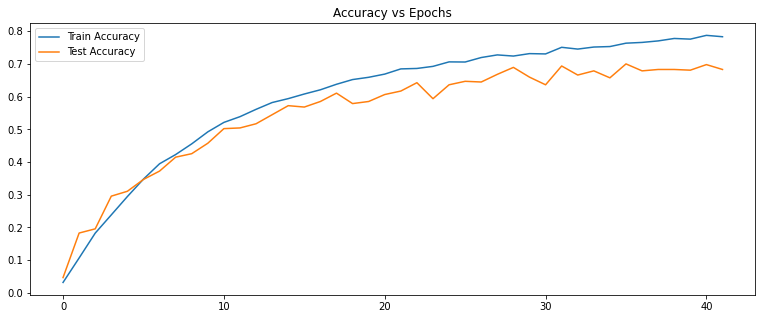

In [ ]:
#Plot the graph to check training and testing accuracy over the period of time
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
y_pred = model.predict(x_test)
predicted_classes=[]
for i in range(len(y_test)):
    predicted_classes.append(np.argmax(y_pred[i]))

15/15 [==============================] - 1s 22ms/step


In [ ]:
#Test Accuracy
accuracy_score(y_test, predicted_classes)

0.6787234042553192

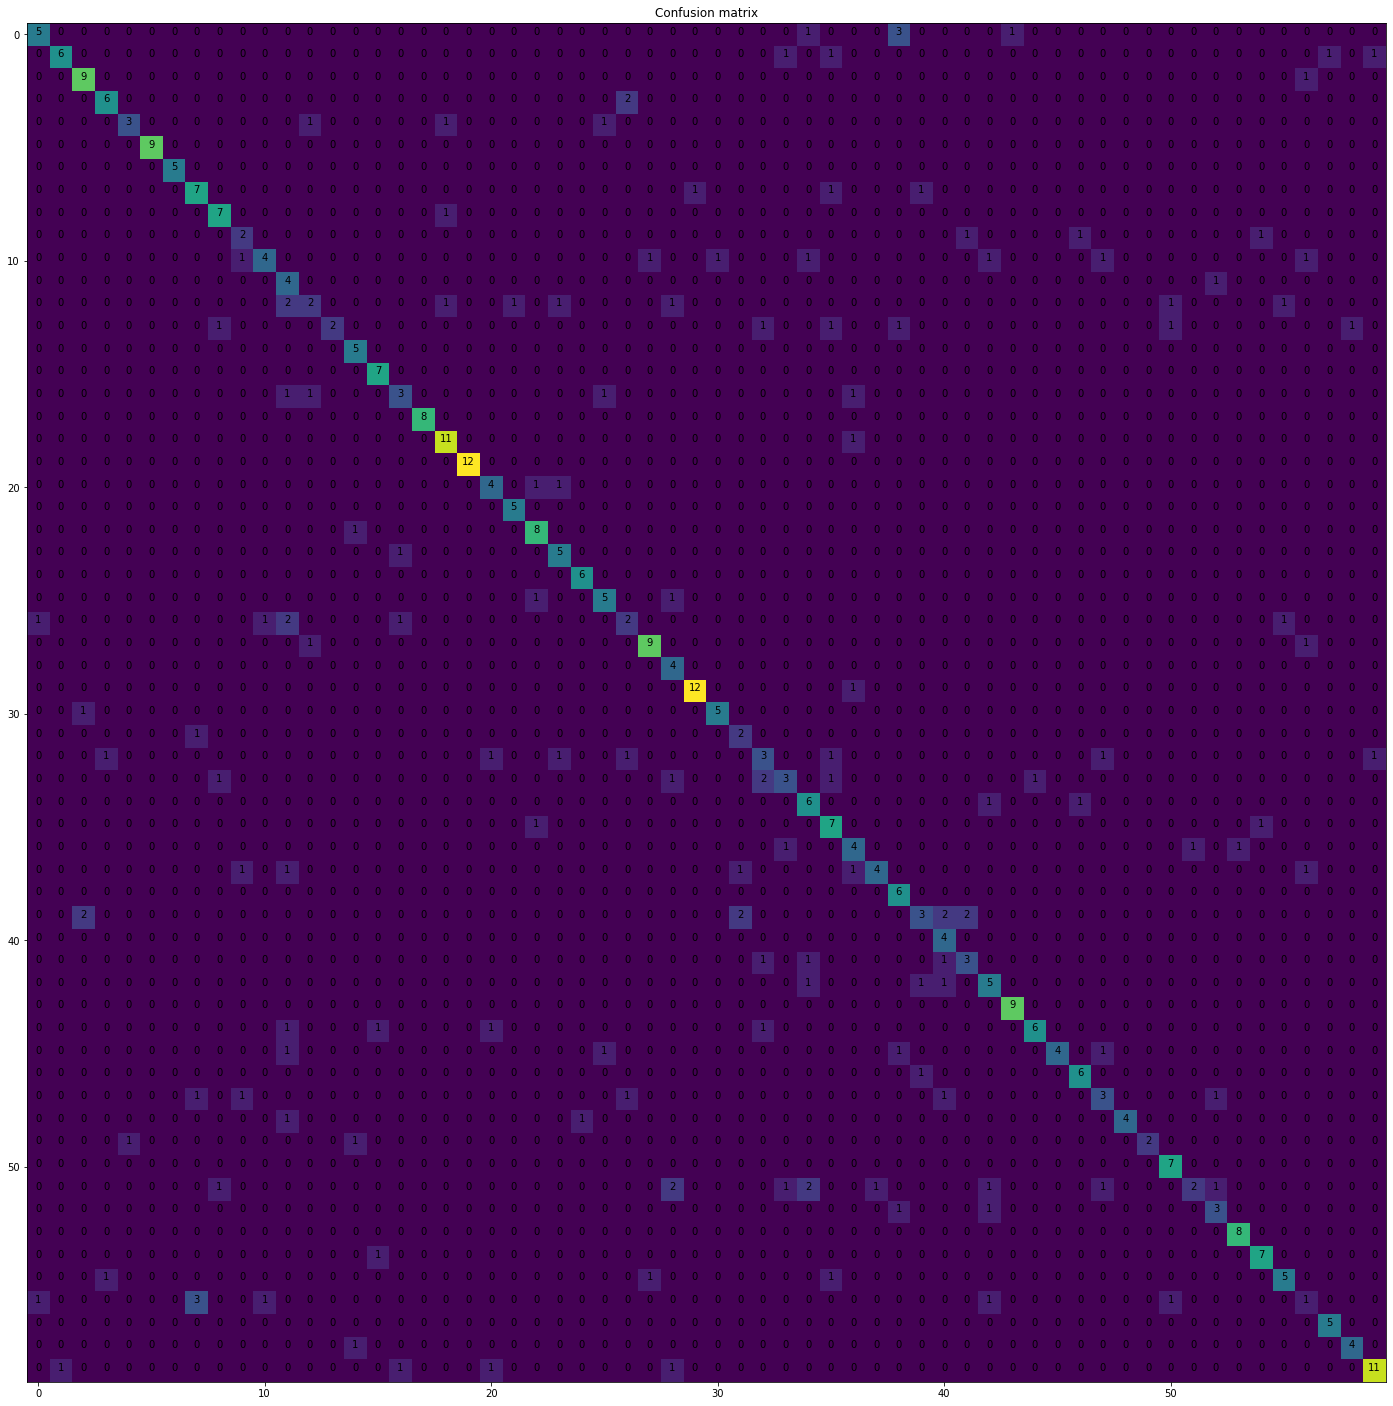

In [ ]:
#Confusion Matrix
plt.figure(figsize=(25,25))
plt.title("Confusion matrix")
cm=confusion_matrix(y_test, predicted_classes)
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.show()

In [ ]:
model.save('CNN_Model.h5')